---
Analyzing Central Bank Speeches and Interest Rate Decisions Using NLP
---


# Project Overview:
This project investigates the relationship between central bank communications and interest rate decisions by analyzing speeches from Federal Reserve Chairs (Powell, Yellen, Bernanke) and European Central Bank (ECB) officials. Using FinBERT, a financial sentiment classification model, speeches are categorized as Hawkish (Bullish), Neutral, or Dovish (Bearish) (multi-class classification) to determine whether sentiment aligns with subsequent interest rate changes.

Possible applications include exchange rate forecasting, improving investment strategies by anticipating monetary policy shifts, and providing insights for policymakers on the impact of central bank communications on financial markets.

For central bank policies, we use hawkish to refer to tightening monetary policy (raising intetest rates, reducing liquidity) to combat inflation while we use dovish to refer to loosening of monetary policy (lowering interest rates, increasing liquidity) to stimulate growth.

In [107]:
# Packages
import pandas as pd
from transformers import BertTokenizer, BertForSequenceClassification
import torch
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.dates as mdates
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import warnings
warnings.filterwarnings("ignore")


# Model Selection
For this project, FinBERT was selected as the primary model for sentiment classification of European Central Bank and Federal Reserve speeches. FinBERT is a fine-tuned version of BERT, specifically trained on financial texts, making it more effective than general NLP models for understanding monetary policy sentiment.

## Model comparison

| Model | Advantages | Disadvantages |
|-------|------------|--------------|
| **LSTM (Long Short-Term Memory)** | - Good for sequential data processing (e.g., time-series analysis). <br> - Captures dependencies between words. | - Requires **large labeled datasets** for training. <br> - Struggles with **longer-range dependencies** in text. <br> - Not pre-trained for financial text. |
| **BERT (Base Model)** | - Context-aware NLP model that understands word relationships. <br> - Handles **long documents** (good for speeches). | - Requires **fine-tuning on financial text** to perform well. <br> - Not optimized for **monetary policy sentiment**. |
| **FinBERT (Chosen Model)** | - **Pre-trained on financial text**, making it better at understanding **central bank speeches**. <br> - Requires **less training data** to achieve good performance. <br> - Supports **multi-class sentiment analysis** (*Hawkish, Neutral, Dovish*). | - Still needs some **fine-tuning** on central bank-specific language. <br> - **Computationally expensive** for large-scale inference. |
| **RoBERTa (Robust BERT)** | - More robust and better trained than standard BERT. <br> - Can handle **complex sentence structures**. | - Requires **extensive fine-tuning** for financial sentiment. <br> - **More computationally expensive** than FinBERT. |



## Why FinBERT
FinBERT is optimized for financial sentiment analysis as it is trained on financial reports and news. It also handles central bank speeches better than LSTM, which struggles with longer, complex sentences. Since FinBERT has been pre-trained, it will be less computationally expensive that training BERT or RoBERTa from scratch.

## Transfer Learning
FinBERT is already trained on financial news and reports, making it better suited for understanding monetary policy discussions compared to general-purpose language models like BERT or RoBERTa.

Instead of training a model from scratch (which requires extensive labeled data), I have chosen to use the ProsusAI/finbert model rather than the yiyanghkust/finbert-tone variant. While both models are built on the FinBERT architecture, ProsusAI’s version has been specifically fine-tuned for financial sentiment analysis, making it more suitable for classifying economic and policy-driven statements. In contrast, yiyanghkust’s version was fine-tuned on analyst reports, which may introduce biases that are not directly aligned with central bank communications. Notably, when tested, the yiyanghkust model tended to predict more bullish (hawkish) sentiments and had lower accuracy in my dataset, likely due to differences in its training data.

I then leveraged ProsusAI/finbert by applying transfer learning to fine-tune it on speeches from the European Central Bank and the Federal Reserve. These speeches contain rich information about monetary policy and market expectations, but they often use complex, domain-specific language. By applying transfer learning, I adapted the model to better recognize sentiment patterns in these specific texts, allowing it to classify sentiments (such as bullish (hawkish) or bearish (dovish) tones) with greater accuracy.

This process allowed me to effectively use a robust, domain-specific model without needing a large, manually labeled dataset from scratch. Instead, I capitalized on the model’s prior learning and further trained it on my corpus of central bank speeches, enhancing its ability to interpret sentiment in these critical financial communications.


In [108]:
# model = BertForSequenceClassification.from_pretrained('yiyanghkust/finbert-pretrain',num_labels=3)
# tokenizer = BertTokenizer.from_pretrained('yiyanghkust/finbert-pretrain')
tokenizer = BertTokenizer.from_pretrained("ProsusAI/finbert")
model = BertForSequenceClassification.from_pretrained("ProsusAI/finbert")
# Function to classify sentiment using finbert-tone
def classify_sentiment(text):
    inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True, max_length=512)
    outputs = model(**inputs)
    sentiment = torch.argmax(outputs.logits).item()
    
    sentiment_mapping = {0: "Bearish (Dovish)", 1: "Neutral", 2: "Bullish (Hawkish)"}
    return sentiment_mapping[sentiment]

# Data Selection: The importance of Central Bank speeches in Financial Markets
Central bank speeches play a crucial role in shaping financial markets, as they provide insights into monetary policy outlooks, economic conditions, and future rate decisions. Investors, analysts, and policymakers closely watch these speeches for forward guidance, where central banks signal their future policy stance to manage market expectations. Statements from key figures like the Federal Reserve Chair or European Central Bank President can impact interest rates, exchange rates, and asset prices.

Despite their significance, there is a lack of publicly available, sentiment-labeled datasets for central bank speeches. Unlike financial news, which often comes with analyst sentiment annotations, monetary policy statements require domain-specific understanding. This makes FinBERT a better choice, as it is pre-trained on financial text, reducing the need for extensive manual labeling while providing accurate sentiment classifications relevant to monetary policy (e.g., Hawkish, Neutral, Dovish).

## Why European Central Bank and the Federal Reserve?
The European Central Bank (ECB) and the Federal Reserve (Fed) are the two most powerful and widely followed monetary authorities. Their policy decisions and communications impact global markets, making them the ideal focus for this project.

The Federal Reserve (Fed) controls the U.S. dollar (USD), the world’s primary reserve currency. Fed policies influence global trade, investment flows, and capital markets.
The European Central Bank (ECB) governs the euro (€), the second most traded currency globally. The eurozone is a major economic bloc, making ECB policy decisions crucial to international markets.

# European Central Bank
The European Central Bank (ECB) is the central bank for the Eurozone, responsible for managing the euro and setting monetary policy for the 20 countries that use it. Its primary mandate is to maintain price stability, typically defined as keeping inflation around 2%.

The ECB operates independently and makes decisions through its Governing Council, which consists of the ECB President, Executive Board members, and central bank governors from Eurozone countries.

Key functions of the ECB include:

1. Setting interest rates to control inflation and economic growth.
2. Conducting monetary policy, including asset purchases and liquidity measures.
3. Supervising banks through the Single Supervisory Mechanism (SSM).
4. Ensuring financial stability across the Eurozone.

The ECB plays a crucial role in economic crises, such as the 2008 financial crash and the Eurozone debt crisis, using tools like quantitative easing (QE) and negative interest rates to stabilize the economy.

## Data Sourcing
The dataset used for the European Central Bank speeches are from: [ECB Speeches Dataset](https://www.ecb.europa.eu/press/key/html/downloads.en.html)

It contains all speeches from the 1990s to 2025. 

The dataset used for the European Central Bank interest rates are from: [ECB Interest Rates](https://data.ecb.europa.eu/data/data-categories/ecbeurosystem-policy-and-exchange-rates/official-interest-rates). 


## Data Preparation
To clean the datasets, firstly, for the interest dataset, I only kept columns that contained the change in interest rates. 
These columns are: 

1. Date: To know when the rate changes happened
   
2. Deposit Facility Change: This refers to changes in the interest rate that the ECB pays on deposits held by commercial banks overnight. It is a key tool for monetary policy as it influences short-term interest rates and liquidity conditions in the eurozone.

3. Marginal Lending Change: This represents changes in the interest rate that commercial banks pay when borrowing overnight from the ECB. This serves as a ceiling for short-term money market rates.

4. Main Refinancing Change: This indicates changes in the main refinancing operations (MRO) rate, which is the rate at which banks can borrow from the ECB for one week. It is the primary interest rate that guides overall monetary policy in the eurozone.

Secondly, I removed rows where the "contents" column contains empty values. These rows are empty because the European Central Bank does not provide transcripts for speeches that were only published as slides. 

Lastly, I converted the "date" column from string to datetime format as this will help with time-based analysis like analysing interest rate trends overtime.

In [86]:
ecb_data = pd.read_csv("all_ECB_speeches.csv", delimiter="|", encoding="utf-8")
ecb_data = ecb_data.dropna(subset=["contents"])
print(ecb_data.head(3))

         date           speakers  \
0  2025-01-27  Christine Lagarde   
2  2025-01-15    Luis de Guindos   
5  2024-12-18     Philip R. Lane   

                                               title  \
0  Central bank independence in an era of volatility   
2  The economic outlook and monetary policy in th...   
5          The euro area outlook and monetary policy   

                                            subtitle  \
0  Lamfalussy Lecture by Christine Lagarde, Presi...   
2  Speech by Luis de Guindos, Vice-President of t...   
5  Speech by Philip R. Lane, Member of the Execut...   

                                            contents  
0    SPEECH  Central bank independence in an era ...  
2    SPEECH  The economic outlook and monetary po...  
5    SPEECH  The euro area outlook and monetary p...  


In [87]:
ecb_data = ecb_data.dropna(subset=["contents"])
# Convert date column to datetime format
ecb_data["date"] = pd.to_datetime(ecb_data["date"])
print(ecb_data.head(3))

        date           speakers  \
0 2025-01-27  Christine Lagarde   
2 2025-01-15    Luis de Guindos   
5 2024-12-18     Philip R. Lane   

                                               title  \
0  Central bank independence in an era of volatility   
2  The economic outlook and monetary policy in th...   
5          The euro area outlook and monetary policy   

                                            subtitle  \
0  Lamfalussy Lecture by Christine Lagarde, Presi...   
2  Speech by Luis de Guindos, Vice-President of t...   
5  Speech by Philip R. Lane, Member of the Execut...   

                                            contents  
0    SPEECH  Central bank independence in an era ...  
2    SPEECH  The economic outlook and monetary po...  
5    SPEECH  The euro area outlook and monetary p...  


In [88]:
# Apply sentiment analysis
ecb_data["sentiment"] = ecb_data["contents"].apply(classify_sentiment)

# Print results
print(ecb_data[["date", "title", "sentiment"]])

# Save test results
ecb_data.to_csv("ecb_sentiment.csv", index=False)



           date                                              title  \
0    2025-01-27  Central bank independence in an era of volatility   
2    2025-01-15  The economic outlook and monetary policy in th...   
5    2024-12-18          The euro area outlook and monetary policy   
6    2024-12-16                         Navigating towards neutral   
7    2024-12-16                   Monetary policy in the euro area   
...         ...                                                ...   
2865 1997-05-13  The European Central Bank: independent and acc...   
2866 1997-04-30  The operation of monetary policy in stage thre...   
2867 1997-04-22  Convergence and the role of the European Centr...   
2868 1997-03-10                       Securing the benefits of EMU   
2869 1997-02-07  Conference organised by the Hungarian Banking ...   

              sentiment  
0     Bullish (Hawkish)  
2               Neutral  
5               Neutral  
6      Bearish (Dovish)  
7      Bearish (Dovish)  
...

In [89]:
ecb_sentiment = pd.read_csv("ecb_sentiment.csv", delimiter=",", encoding="utf-8")
ecb_sentiment["date"] = pd.to_datetime(ecb_sentiment["date"])
ecb_sentiment.rename(columns={"date": "DATE"}, inplace=True)

print(ecb_sentiment.head(3))

        DATE           speakers  \
0 2025-01-27  Christine Lagarde   
1 2025-01-15    Luis de Guindos   
2 2024-12-18     Philip R. Lane   

                                               title  \
0  Central bank independence in an era of volatility   
1  The economic outlook and monetary policy in th...   
2          The euro area outlook and monetary policy   

                                            subtitle  \
0  Lamfalussy Lecture by Christine Lagarde, Presi...   
1  Speech by Luis de Guindos, Vice-President of t...   
2  Speech by Philip R. Lane, Member of the Execut...   

                                            contents          sentiment  
0    SPEECH  Central bank independence in an era ...  Bullish (Hawkish)  
1    SPEECH  The economic outlook and monetary po...            Neutral  
2    SPEECH  The euro area outlook and monetary p...            Neutral  


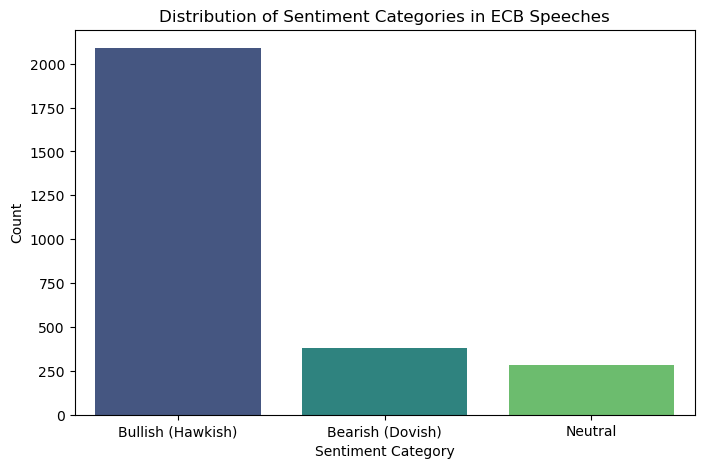

In [109]:
# Exploratory Data Analysis
# Count the number of occurrences of each sentiment label to check for class inbalance
class_counts = ecb_sentiment['sentiment'].value_counts()
# Plot the class distribution
plt.figure(figsize=(8, 5))
sns.barplot(x=class_counts.index, y=class_counts.values, palette="viridis")
plt.xlabel("Sentiment Category")
plt.ylabel("Count")
plt.title("Distribution of Sentiment Categories in ECB Speeches")
plt.show()

In [91]:
ecb_rates = pd.read_csv("ECB_Daily_Interest_rates.csv", delimiter=",", encoding="utf-8")
ecb_rates["DATE"] = pd.to_datetime(ecb_rates["DATE"])
# Select relevant columns (only these columns are relevant to see the change in interest rates)
ecb_rates = ecb_rates[[
    "DATE",
    "Deposit facility - date of changes (raw data) - Change in percentage points compared to previous rate (FM.B.U2.EUR.4F.KR.DFR.CHG)",
    "Marginal lending facility - date of changes (raw data) - Change in percentage points compared to previous rate (FM.B.U2.EUR.4F.KR.MLFR.CHG)",
    "Main refinancing operations - irrespective of which type of rate fixed or variable (date of changes) - Change in percentage points compared to previous rate (FM.B.U2.EUR.4F.KR.MRR.CHG)"
]]
ecb_rates.rename(columns={
    "Deposit facility - date of changes (raw data) - Change in percentage points compared to previous rate (FM.B.U2.EUR.4F.KR.DFR.CHG)": "Deposit_Facility_Change",
    "Marginal lending facility - date of changes (raw data) - Change in percentage points compared to previous rate (FM.B.U2.EUR.4F.KR.MLFR.CHG)": "Marginal_Lending_Change",
    "Main refinancing operations - irrespective of which type of rate fixed or variable (date of changes) - Change in percentage points compared to previous rate (FM.B.U2.EUR.4F.KR.MRR.CHG)": "Main_Refinancing_Change"
}, inplace=True)
rate_change_cols = ["Deposit_Facility_Change","Marginal_Lending_Change","Main_Refinancing_Change"]
ecb_rates = ecb_rates.dropna(subset=rate_change_cols, how="all")
print(ecb_rates.head(3))

         DATE  Deposit_Facility_Change  Marginal_Lending_Change  \
3  1999-01-04                     0.75                    -1.25   
21 1999-01-22                    -0.75                     1.25   
98 1999-04-09                    -0.50                    -1.00   

    Main_Refinancing_Change  
3                       NaN  
21                      NaN  
98                     -0.5  


In [92]:
# Merge sentiment data with rate changes on DATE
merged_data = ecb_sentiment.merge(ecb_rates, on="DATE", how="left")
print(merged_data.head(3)) #NAN in last 3 columns if the speech was given on a date that does not match a rate change date

        DATE           speakers  \
0 2025-01-27  Christine Lagarde   
1 2025-01-15    Luis de Guindos   
2 2024-12-18     Philip R. Lane   

                                               title  \
0  Central bank independence in an era of volatility   
1  The economic outlook and monetary policy in th...   
2          The euro area outlook and monetary policy   

                                            subtitle  \
0  Lamfalussy Lecture by Christine Lagarde, Presi...   
1  Speech by Luis de Guindos, Vice-President of t...   
2  Speech by Philip R. Lane, Member of the Execut...   

                                            contents          sentiment  \
0    SPEECH  Central bank independence in an era ...  Bullish (Hawkish)   
1    SPEECH  The economic outlook and monetary po...            Neutral   
2    SPEECH  The euro area outlook and monetary p...            Neutral   

   Deposit_Facility_Change  Marginal_Lending_Change  Main_Refinancing_Change  
0                      NaN   

## Mapping Interest Rate Decisions to Last relevant speech:

### Why Not Use Same-Date Speeches?
1. Interest rate decisions are typically announced after extensive deliberation, and markets react to expectations rather than the decision itself.
2. Speeches on the same date as a rate change often serve as justifications for the decision, rather than influencing it.
3. Investors and markets react ahead of time, pricing in expectations based on prior speeches.

### Why Use the Last Speech Before a Rate Change?
1. Central bank officials often signal potential rate hikes or cuts in speeches weeks before the actual decision.
2. The goal was to capture the sentiment that shaped market expectations leading up to the rate change.
3. This approach better reflects causality, as the Fed or ECB's decision is often influenced by economic conditions already discussed in previous speeches.

### Implementation Steps: 
1. Sort both datasets by date.
2. For each rate decision, identified the most recent speech before that date.
3. Matched sentiment labels (Hawkish, Neutral, Dovish) to the corresponding rate decision.
4. Dropped instances where no prior speech existed (e.g., first available rate change in the dataset).

The same thing is also done for the Federal Reserve datasets below

In [93]:
# Ensure dates are sorted in ascending order
ecb_sentiment = ecb_sentiment.sort_values("DATE")
ecb_rates = ecb_rates.sort_values("DATE")

# Create a new column to store the last speech before each rate change
ecb_rates["Previous_Speech_Sentiment"] = None

# Iterate over rate changes
for i, row in ecb_rates.iterrows():
    rate_date = row["DATE"]
    
    # Find the most recent speech before the rate change
    past_speeches = ecb_sentiment[ecb_sentiment["DATE"] < rate_date].sort_values("DATE", ascending=False)
    
    if not past_speeches.empty:
        last_speech = past_speeches.iloc[0]  # Most recent speech
        ecb_rates.at[i, "Previous_Speech_Sentiment"] = last_speech["sentiment"]

# Display updated dataset
ecb_rates=ecb_rates.sort_values("DATE")
print(ecb_rates.head(3))

         DATE  Deposit_Facility_Change  Marginal_Lending_Change  \
3  1999-01-04                     0.75                    -1.25   
21 1999-01-22                    -0.75                     1.25   
98 1999-04-09                    -0.50                    -1.00   

    Main_Refinancing_Change Previous_Speech_Sentiment  
3                       NaN         Bullish (Hawkish)  
21                      NaN         Bullish (Hawkish)  
98                     -0.5         Bullish (Hawkish)  


In [94]:
# Calculate the month-over-month change in the Federal Funds Rate
ecb_rates["Rate_Change"] = ecb_rates["Main_Refinancing_Change"].diff() 
# Define classification function
def classify_rate_change(change, threshold=0.05):  # Adjust threshold if needed
    if change > threshold:
        return "Bullish (Hawkish)"  # Hawkish (Increase)
    elif change < -threshold:
        return "Bearish (Dovish)"  # Dovish (Decrease)
    else:
        return "Neutral"  # Neutral (Stable)

# Apply classification function
ecb_rates["Actual_Sentiment"] = ecb_rates["Rate_Change"].apply(classify_rate_change)

# Display the updated dataset
print(ecb_rates.head(3))


         DATE  Deposit_Facility_Change  Marginal_Lending_Change  \
3  1999-01-04                     0.75                    -1.25   
21 1999-01-22                    -0.75                     1.25   
98 1999-04-09                    -0.50                    -1.00   

    Main_Refinancing_Change Previous_Speech_Sentiment  Rate_Change  \
3                       NaN         Bullish (Hawkish)          NaN   
21                      NaN         Bullish (Hawkish)          NaN   
98                     -0.5         Bullish (Hawkish)          NaN   

   Actual_Sentiment  
3           Neutral  
21          Neutral  
98          Neutral  


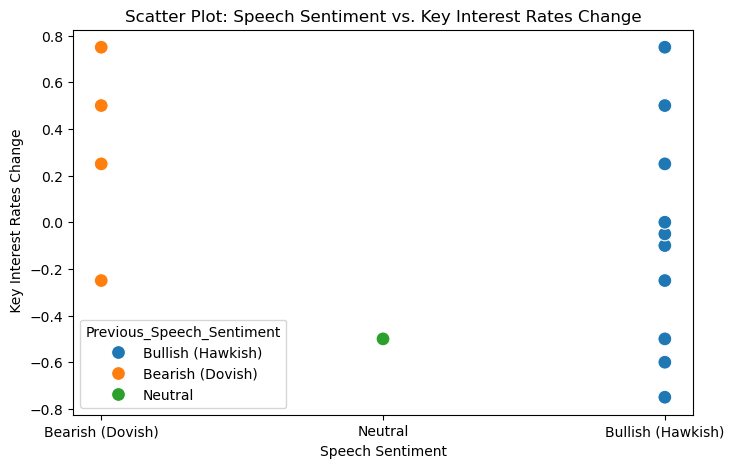

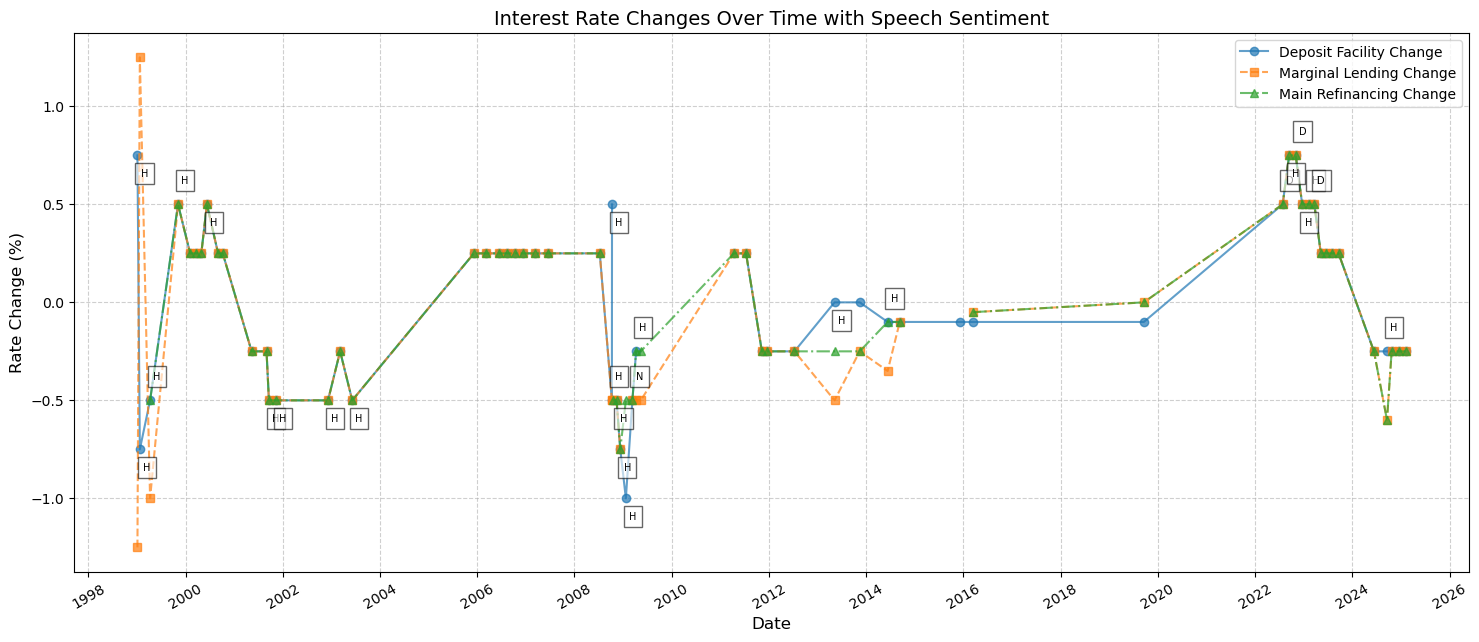

In [95]:
# Plotting based on the final dataframe `ecb_rates`
# Applying sentiment mapping
sentiment_mapping = {
    "Bullish (Hawkish)": 1,
    "Neutral": 0,
    "Bearish (Dovish)": -1
}

# Map sentiment to numeric values for visualization
ecb_rates["Sentiment_Score"] = ecb_rates["Previous_Speech_Sentiment"].map(sentiment_mapping)

# 1. Scatter Plot of Sentiment vs. Rate Change
plt.figure(figsize=(8, 5))
sns.scatterplot(x=ecb_rates["Sentiment_Score"], y=ecb_rates["Main_Refinancing_Change"], hue=ecb_rates["Previous_Speech_Sentiment"], s=100)
plt.xticks([-1, 0, 1], ["Bearish (Dovish)", "Neutral", "Bullish (Hawkish)"])
plt.title("Scatter Plot: Speech Sentiment vs. Key Interest Rates Change")
plt.ylabel(" Key Interest Rates Change")
plt.xlabel("Speech Sentiment")
plt.show()

# 2. Time Series Line Plot with Rate Change Annotations
sentiment_mapping = {
    "Bullish (Hawkish)": "H",
    "Neutral": "N",
    "Bearish (Dovish)": "D"
}

# Replace sentiment labels with short labels
ecb_rates["Short_Sentiment"] = ecb_rates["Previous_Speech_Sentiment"].map(sentiment_mapping)

# Set up figure
plt.figure(figsize=(18, 7))

# Plot each interest rate change with improved transparency and markers
plt.plot(ecb_rates["DATE"], ecb_rates["Deposit_Facility_Change"], marker='o', linestyle='-', label="Deposit Facility Change", alpha=0.7)
plt.plot(ecb_rates["DATE"], ecb_rates["Marginal_Lending_Change"], marker='s', linestyle='--', label="Marginal Lending Change", alpha=0.7)
plt.plot(ecb_rates["DATE"], ecb_rates["Main_Refinancing_Change"], marker='^', linestyle='-.', label="Main Refinancing Change", alpha=0.7)

# Annotate only significant changes and stagger positions to avoid clutter
for i, row in ecb_rates.iterrows():
    if abs(row["Deposit_Facility_Change"]) > 0.25 or abs(row["Marginal_Lending_Change"]) > 0.25 or abs(row["Main_Refinancing_Change"]) > 0.25:
        y_offset = 15 if i % 2 == 0 else -15  # Stagger annotation positions
        plt.annotate(row["Short_Sentiment"], 
                     (row["DATE"], row["Deposit_Facility_Change"]), 
                     textcoords="offset points", xytext=(5, y_offset), ha='center', fontsize=7, 
                     bbox=dict(facecolor='white', edgecolor='black', alpha=0.6))

# Formatting
plt.title("Interest Rate Changes Over Time with Speech Sentiment", fontsize=14)
plt.xlabel("Date", fontsize=12)
plt.ylabel("Rate Change (%)", fontsize=12)
plt.xticks(rotation=30)
plt.legend(loc="best", fontsize=10)
plt.grid(True, linestyle='--', alpha=0.6)

# Improve x-axis labels
plt.gca().xaxis.set_major_locator(mdates.YearLocator(2))  # Tick every 2 years
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

# Show plot
plt.show()


## Evaluation of Results
Below is a summary of the European Central Bank's key policy focus, stance, and significant events across different periods:

| **Period**       | **Policy Focus**                                      | **Key Events**                                     | **Stance**                                  |
|-----------------|------------------------------------------------------|---------------------------------------------------|---------------------------------------------|
| **2000–2008**   | Maintaining price stability, gradual rate hikes       | Pre-2008 Financial Crisis, steady growth         | **Hawkish (Rate Hikes)**                    |
| **2008–2012**   | Crisis response, liquidity injection, easing credit   | Global Financial Crisis, Eurozone debt crisis    | **Dovish (Stimulus & Rate Cuts)**           |
| **2012–2019**   | Ultra-loose monetary policy, QE implementation        | Draghi’s "Whatever it takes" speech, low inflation | **Dovish (Zero/Negative Rates)**            |
| **2020–2022**   | Pandemic response, economic recovery measures         | COVID-19 stimulus, bond-buying programs         | **Highly Dovish (QE & Liquidity)**          |
| **2022–Present**| Inflation control, quantitative tightening            | High inflation, rapid rate hikes                | **Hawkish (Aggressive Tightening)**         |

### Scatter Plots:

The **Scatter Plots** for the ECB show how sentiment classifications (Hawkish, Neutral, and Dovish) relate to changes in key interest rates—Deposit Facility, Marginal Lending, and Main Refinancing.

Deposit Facility Rate Changes:

- There is a visible relationship between hawkish sentiment and rate increases, and dovish sentiment and rate cuts.
- However, some outliers suggest that in certain instances, hawkish sentiment did not result in an immediate rate hike, indicating other macroeconomic factors at play.

Main Refinancing Rate Changes:

- The ECB's main refinancing operations (MRO) are the primary benchmark rates for monetary policy.
- As seen in the scatter plot, Bullish (Hawkish) speeches are more often associated with positive rate changes, whereas Bearish (Dovish) speeches correspond to rate cuts.
- Some neutral speeches also appear before rate hikes or cuts, showing that ECB officials might sometimes maintain neutral rhetoric before adjusting policy.

### Time-Series Graphs:

The time-series visualization of ECB interest rates suggests several key observations:

1. Alignment Between Sentiment and Rate Decisions:

- The ECB follows a structured approach to interest rate setting, and the graphs show that major rate increases align with periods of hawkish sentiment.
- Conversely, significant rate cuts, such as those around the 2008 financial crisis and the 2020 COVID-19 crisis, align with increased dovish sentiment.

2. Market Conditions and External Shocks Influence Decisions:

- The ECB had to deviate from sentiment-based expectations during crisis periods.
- For example, despite hawkish rhetoric in certain periods, rate cuts were implemented due to economic downturns, reinforcing the idea that external shocks override policy expectations.

3. Consistency Across Interest Rate Instruments:

- The changes in Deposit Facility, Marginal Lending, and Main Refinancing rates tend to follow similar patterns, although the magnitude of changes varies.
- This suggests that sentiment analysis may be a better predictor of broad policy direction rather than specific rate instruments.


# United States Federal Reserve
The Federal Reserve (the Fed) is the central bank of the United States, responsible for monetary policy, financial stability, and economic growth. It manages interest rates, regulates banks, and controls the money supply to achieve its dual mandate: maximum employment and stable inflation.

Since 2006, three Federal Reserve Chairs have played crucial roles in shaping U.S. monetary policy, each responding to the unique economic challenges during their time, using monetary policy to balance growth, inflation and financial stability.

The 3 chairs I have selected are:
1. Ben Bernanke (2006–2014): Led the Fed through the 2008 Global Financial Crisis, implementing massive quantitative easing (QE) and slashing interest rates to stabilize the economy.
2. Janet Yellen (2014–2018): Focused on labor market recovery and oversaw a gradual increase in interest rates while ensuring steady economic growth.
3. Jerome Powell (2018–Present): Managed the COVID-19 economic crisis, implementing aggressive stimulus, and later shifted to hawkish rate hikes in 2022 to combat high inflation.



## Data Sourcing
The dataset used for the Federal Reserve speeches are from: [BIS Central Bank Speeches ](https://www.bis.org/cbspeeches/index.htm?m=256&countries=191&authors=251)

It contains full text extract of speeches delivered by over 100 central bankers since 1996

The dataset used for the Federal Reserve interest rates are from:[Federal Reserve Funds](https://fred.stlouisfed.org/series/FEDFUNDS)

It is managed by the Federal Reserve Bank of St. Louis and tracks the effective federal funds rate, which is the interest rate at which depository institutions lend reserves to each other overnight. It is a key benchmark rate that influences overall borrowing costs in the U.S. economy.

## Data Preparation
To clean the datasets, firstly, I had to filter out the speeches dataset from BIS to remove speeches from all other central banks. 
Once I had the speeches made by only the Federal Reserve Bankers, I filtered further to select only the speeches made by the Federal Reserve Chairs.
While the Federal Open Market Committee (FOMC) consists of multiple board members who contribute to monetary policy decisions, the Chair holds the most influential position. 

Roles of the Chair include:

1. Sets the overall direction of policy and communicates decisions to the public and financial markets.
   
2. Is the primary spokesperson for monetary policy outlooks and economic conditions.
   
3. Drives the Fed’s response to major economic crises, as seen during the 2008 financial crash and COVID-19 pandemic.

Analyzing the Chair’s speeches provides a clearer understanding of the Fed’s policy stance, forward guidance, and its impact on financial markets, particularly on interest rates and the U.S. dollar.

I selected these 3 Chairs in particular because they each because they each navigated distinct economic crises and policy shifts—Bernanke during the 2008 financial crisis, Yellen in a period of post-crisis recovery, and Powell through the COVID-19 pandemic and subsequent inflation surge—offering a comprehensive view of how monetary policy sentiment aligns with major economic events.

Secondly, I removed rows where the the text column contains NaN values and dropped the URL column as it is not needed for analysis.
Lastly, similarly to the ECB datasets, I also converted the "date" column from string to datetime format as this will help with time-based analysis like analysing interest rate trends overtime.

In [96]:
fed_speeches = pd.read_csv("fed_speeches.csv", delimiter=",", encoding="utf-8")
fed_speeches.drop(columns=["url"], inplace=True)
fed_speeches = fed_speeches.dropna(subset=["text"])
print(fed_speeches.head(3))


                                               title  \
0  Ben S Bernanke: Deflation - making sure 'it' d...   
1  Ben S Bernanke: Asset-price ¿bubbles¿ and mone...   
2  Ben S Bernanke: The influence of Milton Friedm...   

                                         description                 date  \
0  Speech by Mr Ben S Bernanke, Member of the Boa...  2002-11-21 00:00:00   
1  Speech by Mr Ben S Bernanke, Member of the Boa...  2002-10-15 00:00:00   
2  Remarks by Mr Ben S Bernanke, Member of the Bo...  2003-10-24 00:00:00   

                                                text          author  
0  Ben S Bernanke: Deflation - making sure "it" d...  Ben S Bernanke  
1  Ben S Bernanke: Asset-price "bubbles" and mone...  Ben S Bernanke  
2  Ben S Bernanke: The influence of Milton Friedm...  Ben S Bernanke  


In [97]:
fed_speeches["sentiment"] = fed_speeches["text"].apply(classify_sentiment)
fed_speeches.to_csv("fed_sentiment.csv", index=False)


In [98]:
fed_sentiment = pd.read_csv("fed_sentiment.csv",delimiter=",", encoding="utf-8")
fed_sentiment["date"] = pd.to_datetime(fed_sentiment["date"])
print(fed_sentiment.head(3))

                                               title  \
0  Ben S Bernanke: Deflation - making sure 'it' d...   
1  Ben S Bernanke: Asset-price ¿bubbles¿ and mone...   
2  Ben S Bernanke: The influence of Milton Friedm...   

                                         description       date  \
0  Speech by Mr Ben S Bernanke, Member of the Boa... 2002-11-21   
1  Speech by Mr Ben S Bernanke, Member of the Boa... 2002-10-15   
2  Remarks by Mr Ben S Bernanke, Member of the Bo... 2003-10-24   

                                                text          author  \
0  Ben S Bernanke: Deflation - making sure "it" d...  Ben S Bernanke   
1  Ben S Bernanke: Asset-price "bubbles" and mone...  Ben S Bernanke   
2  Ben S Bernanke: The influence of Milton Friedm...  Ben S Bernanke   

           sentiment  
0            Neutral  
1  Bullish (Hawkish)  
2  Bullish (Hawkish)  


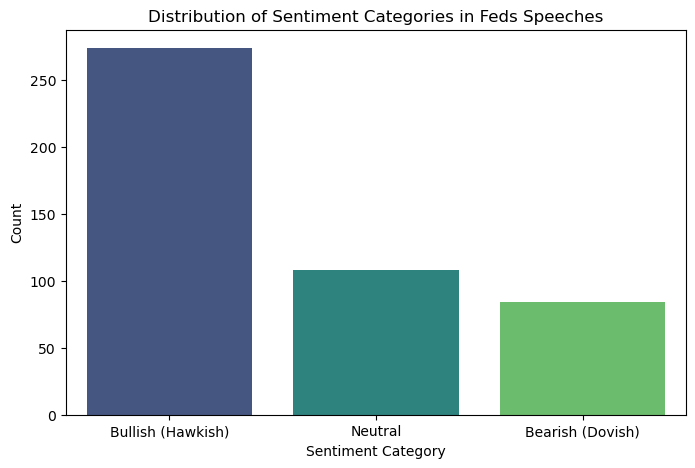

In [110]:
# Exploratory Data Analysis
# Count the number of occurrences of each sentiment label to check for class inbalance
class_counts = fed_sentiment['sentiment'].value_counts()
# Plot the class distribution
plt.figure(figsize=(8, 5))
sns.barplot(x=class_counts.index, y=class_counts.values, palette="viridis")
plt.xlabel("Sentiment Category")
plt.ylabel("Count")
plt.title("Distribution of Sentiment Categories in Feds Speeches")
plt.show()

In [100]:
fed_interest = pd.read_csv("fed_interest.csv", delimiter=",", encoding="utf-8")
fed_interest.rename(columns={"observation_date": "date"}, inplace=True)
fed_interest["date"] = pd.to_datetime(fed_interest["date"])
print(fed_interest.head(3))

        date  FEDFUNDS
0 2000-01-01      5.45
1 2000-02-01      5.73
2 2000-03-01      5.85


In [101]:
merged_data_usa = fed_sentiment.merge(fed_interest, on="date", how="left")
print(merged_data_usa.head(3))

                                               title  \
0  Ben S Bernanke: Deflation - making sure 'it' d...   
1  Ben S Bernanke: Asset-price ¿bubbles¿ and mone...   
2  Ben S Bernanke: The influence of Milton Friedm...   

                                         description       date  \
0  Speech by Mr Ben S Bernanke, Member of the Boa... 2002-11-21   
1  Speech by Mr Ben S Bernanke, Member of the Boa... 2002-10-15   
2  Remarks by Mr Ben S Bernanke, Member of the Bo... 2003-10-24   

                                                text          author  \
0  Ben S Bernanke: Deflation - making sure "it" d...  Ben S Bernanke   
1  Ben S Bernanke: Asset-price "bubbles" and mone...  Ben S Bernanke   
2  Ben S Bernanke: The influence of Milton Friedm...  Ben S Bernanke   

           sentiment  FEDFUNDS  
0            Neutral       NaN  
1  Bullish (Hawkish)       NaN  
2  Bullish (Hawkish)       NaN  


Similar to the ECB dataset, for the Federal Reserve dataset, the "Interest Rate Decisions" is also mapped to "Last relevant speech"

In [102]:
# Ensure dates are sorted in ascending order
fed_speeches["date"] = pd.to_datetime(fed_speeches["date"])
fed_interest["date"] = pd.to_datetime(fed_interest["date"])
fed_speeches = fed_speeches.sort_values("date")
fed_interest = fed_interest.sort_values("date")


# Create a new column to store the last speech sentiment before each rate change
fed_interest["Previous_Speech_Sentiment"] = None

# Iterate over rate changes
for i, row in fed_interest.iterrows():
    rate_date = row["date"]
    
    # Find the most recent speech before the rate change
    past_speeches = fed_speeches[fed_speeches["date"] < rate_date].sort_values("date", ascending=False)
    
    if not past_speeches.empty:
        last_speech = past_speeches.iloc[0]  # Most recent speech
        fed_interest.at[i, "Previous_Speech_Sentiment"] = last_speech["sentiment"]
        fed_interest.at[i, "Previous_Speech_Author"] = last_speech["author"]  # Store author
        
fed_interest=fed_interest.sort_values("date")

# Remove rows where Previous_Speech_Sentiment is None
fed_interest = fed_interest.dropna(subset=["Previous_Speech_Sentiment"])

print(fed_interest.head(3))

         date  FEDFUNDS Previous_Speech_Sentiment Previous_Speech_Author
34 2002-11-01      1.34         Bullish (Hawkish)         Ben S Bernanke
35 2002-12-01      1.24                   Neutral         Ben S Bernanke
36 2003-01-01      1.24                   Neutral         Ben S Bernanke


In [103]:
# Calculate the month-over-month change in the Federal Funds Rate
fed_interest["Rate_Change"] = fed_interest["FEDFUNDS"].diff() 
# Define classification function
def classify_rate_change(change, threshold=0.05):  # Adjust threshold if needed
    if change > threshold:
        return "Bullish (Hawkish)"  # Hawkish (Increase)
    elif change < -threshold:
        return "Bearish (Dovish)"  # Dovish (Decrease)
    else:
        return "Neutral"  # Neutral (Stable)

# Apply classification function
fed_interest["Actual_Sentiment"] = fed_interest["Rate_Change"].apply(classify_rate_change)

# Display the updated dataset
print(fed_interest.head(3))


         date  FEDFUNDS Previous_Speech_Sentiment Previous_Speech_Author  \
34 2002-11-01      1.34         Bullish (Hawkish)         Ben S Bernanke   
35 2002-12-01      1.24                   Neutral         Ben S Bernanke   
36 2003-01-01      1.24                   Neutral         Ben S Bernanke   

    Rate_Change  Actual_Sentiment  
34          NaN           Neutral  
35         -0.1  Bearish (Dovish)  
36          0.0           Neutral  


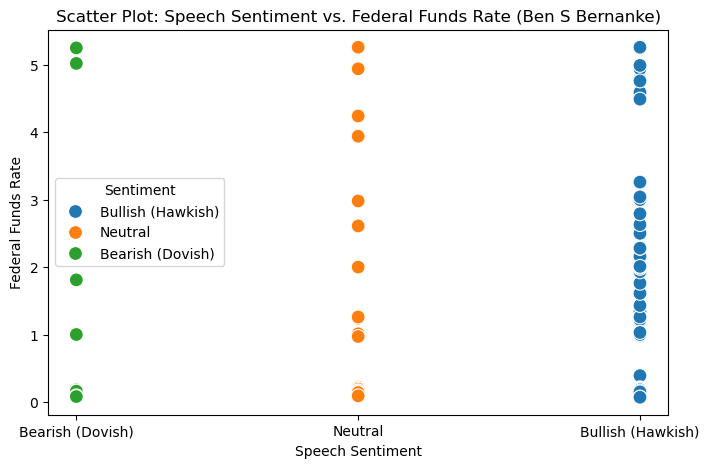

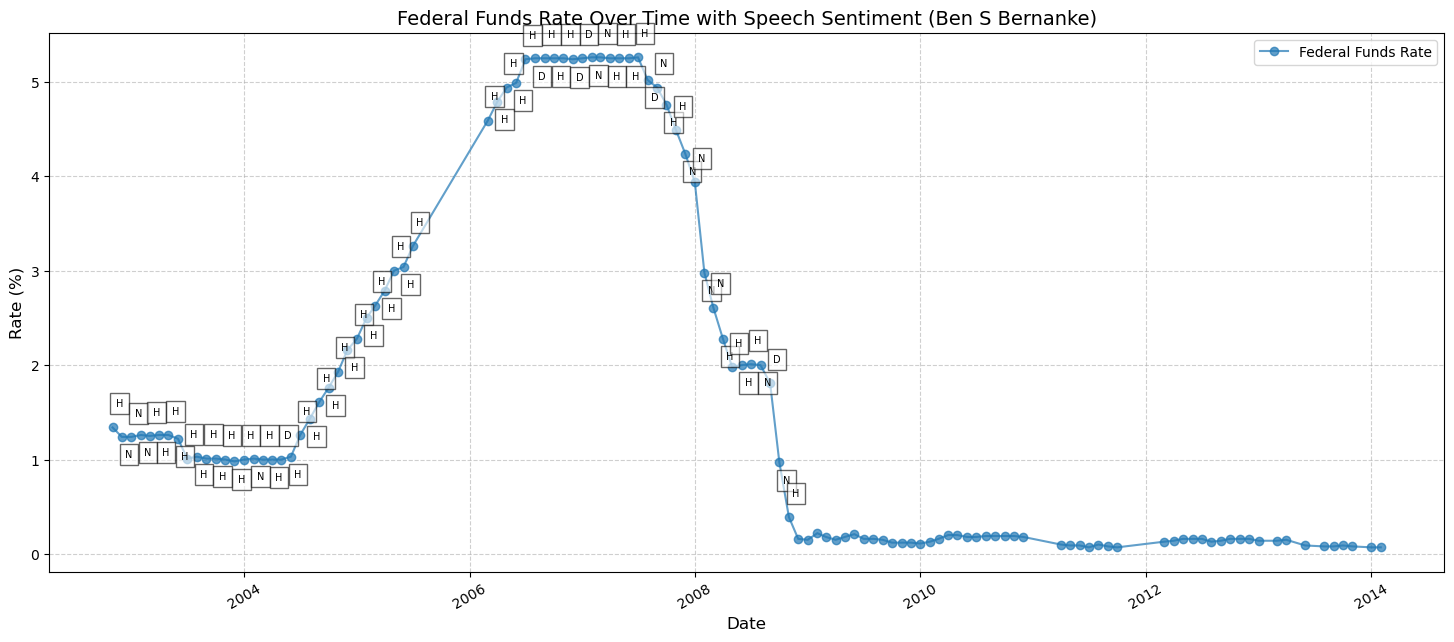

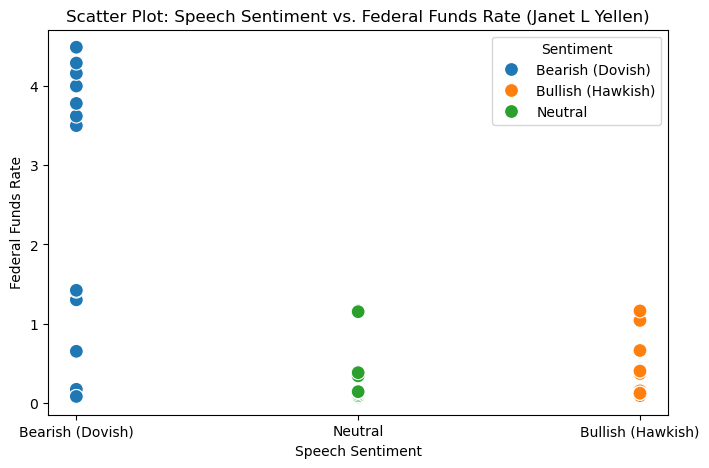

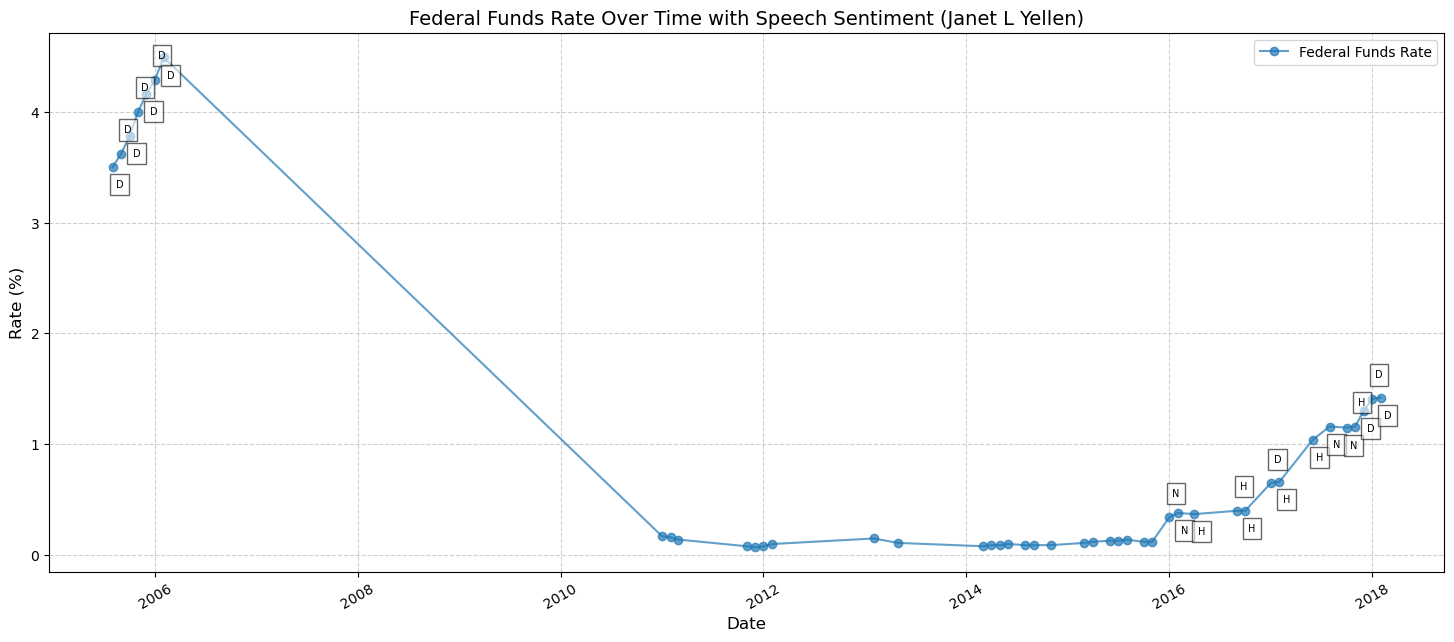

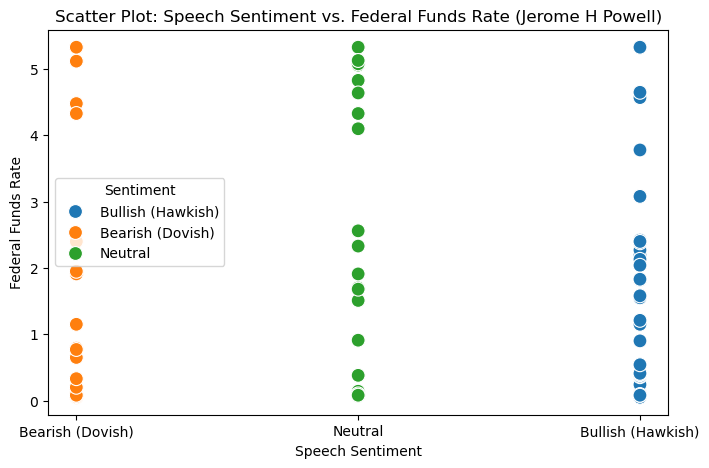

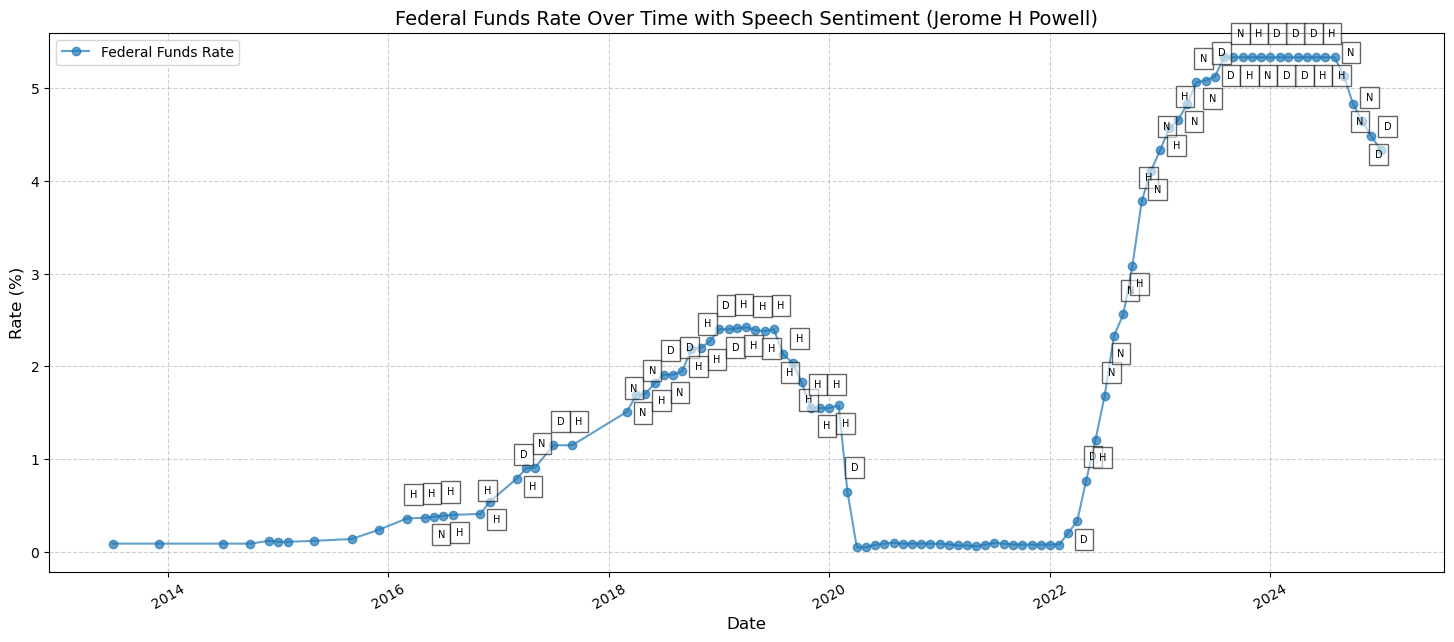

In [104]:
# Applying sentiment mapping for the Fed dataset
sentiment_mapping = {
    "Bullish (Hawkish)": 1,
    "Neutral": 0,
    "Bearish (Dovish)": -1
}

short_sentiment_mapping = {
    "Bullish (Hawkish)": "H",
    "Neutral": "N",
    "Bearish (Dovish)": "D"
}

# List of authors to filter by
fed_chairs = ["Ben S Bernanke", "Janet L Yellen", "Jerome H Powell"] 
# Spliting into 3 separate sets of graph helps with visualisation given their different economic stance. The number of interest rate datapoints makes the graph overcrowded as well

# Iterate through each Fed chair and generate separate graphs
for chair in fed_chairs:
    fed_subset = fed_interest[fed_interest["Previous_Speech_Author"] == chair].copy()

    # Skip if there's not enough data
    if fed_subset.empty:
        continue

    # Map sentiment to numeric values for visualization
    fed_subset["Sentiment_Score"] = fed_subset["Previous_Speech_Sentiment"].map(sentiment_mapping)
    fed_subset["Short_Sentiment"] = fed_subset["Previous_Speech_Sentiment"].map(short_sentiment_mapping)

    ### 1. Scatter Plot: Speech Sentiment vs. Federal Funds Rate Change ###
    plt.figure(figsize=(8, 5))
    sns.scatterplot(x=fed_subset["Sentiment_Score"], y=fed_subset["FEDFUNDS"], hue=fed_subset["Previous_Speech_Sentiment"], s=100)
    plt.xticks([-1, 0, 1], ["Bearish (Dovish)", "Neutral", "Bullish (Hawkish)"])
    plt.title(f"Scatter Plot: Speech Sentiment vs. Federal Funds Rate ({chair})")
    plt.ylabel("Federal Funds Rate")
    plt.xlabel("Speech Sentiment")
    plt.legend(title="Sentiment", loc="best")
    plt.show()

    ### 2. Time Series Line Plot: Federal Funds Rate Over Time with Speech Sentiment ###
    plt.figure(figsize=(18, 7))

    # Plot Federal Funds Rate over time
    plt.plot(fed_subset["date"], fed_subset["FEDFUNDS"], marker='o', linestyle='-', label="Federal Funds Rate", alpha=0.7)

    # Annotate only significant changes and stagger positions to avoid clutter
    for i, row in fed_subset.iterrows():
        if abs(row["FEDFUNDS"]) > 0.25:  # Adjust threshold if needed
            y_offset = 15 if i % 2 == 0 else -15  # Stagger annotation positions
            plt.annotate(row["Short_Sentiment"], 
                         (row["date"], row["FEDFUNDS"]), 
                         textcoords="offset points", xytext=(5, y_offset), ha='center', fontsize=7, 
                         bbox=dict(facecolor='white', edgecolor='black', alpha=0.6))

    # Formatting
    plt.title(f"Federal Funds Rate Over Time with Speech Sentiment ({chair})", fontsize=14)
    plt.xlabel("Date", fontsize=12)
    plt.ylabel("Rate (%)", fontsize=12)
    plt.xticks(rotation=30)
    plt.legend(loc="best", fontsize=10)
    plt.grid(True, linestyle='--', alpha=0.6)

    # Improve x-axis labels
    plt.gca().xaxis.set_major_locator(mdates.YearLocator(2))  # Tick every 2 years
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

    # Show plot
    plt.show()

## Evaluation of Results:
Below is a summary of each Chair's policy focus, stance and key events during their term:

| Chair           | Term            | Policy Focus                                    | Key Event               | Stance                      |
|---------------|---------------|--------------------------------|---------------------|----------------------------|
| **Ben Bernanke**  | 2006 – 2014    | Crisis management, QE, financial stability | 2008 Financial Crisis  | **Dovish** (Stimulus)       |
| **Janet Yellen**  | 2014 – 2018    | Labor market focus, gradual tightening  | Post-crisis recovery, low inflation | **Dovish to Neutral** |
| **Jerome Powell** | 2018 – Present | Inflation control, pandemic response    | COVID-19 Crisis, Inflation Surge | **Hawkish** (since 2022) |

### Scatter Plots:

The **Scatter Plots** reflect how the speech sentiment correlates with the Federal Funds Rate:
For Ben Bernanke (2006-2014):
- Bernanke’s tenure was dominated by the 2008 Financial Crisis, leading to aggressive monetary easing through quantitative easing (QE) and near-zero interest rates.
- The scatter plot reflects this with many dovish (bearish) sentiments during the financial crisis, aligning with his stimulative policy of rate cuts.
- However, the huge number of hawkish (bullish) sentiment points observed was prior to the crisis (2006–2007), corresponding to the period when interest rates were rising in response to economic growth before the crisis hit.

For Janet Yellen (2014-2018):
- Yellen focused on gradual rate hikes while ensuring labor market recovery and inflation stability.
- Her plot shows more neutral speech sentiments, reflecting her measured and data-driven approach to rate increases.
- There are also some hawkish sentiments aligning with the period of gradual rate hikes, showing her cautious tightening stance post-crisis.

For Jerome Powell (2018–Present):
- Powell’s term saw two distinct phases: dovish policy during the COVID-19 pandemic (2020) and hawkish policy from 2022 onwards to combat inflation.
- His scatter plot captures dovish sentiments aligning with near-zero rates during the pandemic and hawkish sentiments coinciding with aggressive rate hikes in 2022.
- The distribution suggests that Powell’s monetary stance shifted significantly in response to economic shocks, demonstrating the most variation in sentiment compared to his predecessors.

### Time-Series Graphs:

The **Time-Series Graphs** are useful in highlighting the discrepancies between predicted sentiment and actual interest rate decisions:

External Factors can override sentiment-driven predictions, leading to policy and interest rates pivots.

One notable instance is 2006-2008, where the predicted sentiment and actual policy decisions diverged significantly. 
During this period, Bernanke’s speeches contained a high frequency of hawkish (H) sentiment, which would typically signal an increase in interest rates to curb inflation or economic overheating. However, the Federal Funds Rate instead plummeted as the financial crisis unfolded.

Another notable instance is during Powell's tenure, which saw significant shifts due to the COVID-19 pandemic and subsequent inflation surge. 
From 2018-2020, speech sentiment varied, with hawkish signals followed by sudden dovish actions in response to the economic downturn caused by the pandemic. This was reflected in the Fed cutting interest rates back to near zero. However, post-2021, hawkish sentiment surged again, aligning with Powell’s aggressive rate hikes in 2022-2023 to combat inflation. This suggests that in highly volatile periods, sentiment aligns more closely with actual policy decisions when central banks are actively responding to economic crises.

The time-series graphs also provides insights which helps us verify the close alignment of speech sentiment and rate changes, especially during stable economic periods.

In contrast to Powell and Bernanke, Yellen's tenure was characterised by a focus on labor market recovery and gradual tightening. The chart reflects a predominantly neutral to slightly hawkish sentiment during her time in office, aligning with the slow but steady increase in interest rates post-2015. Unlike Bernanke, Yellen’s policy decisions were more aligned with her speech sentiments, as she communicated a careful and measured approach to tightening monetary policy. This suggests that during stable economic periods, sentiment analysis can be a more reliable indicator of future rate decisions.

# Comparing Between the Central Banks: A competition or a contrast?
Differences in Predictability:
- The Federal Reserve's interest rate decisions sometimes diverged from sentiment predictions due to emergency interventions, such as during the 2008 financial crisis and the COVID-19 pandemic. In contrast, the ECB’s approach appears more structured and predictable in normal economic conditions.
- The presence of three distinct rate instruments (Deposit Facility, Marginal Lending, and Main Refinancing rates) adds complexity to ECB policy analysis, whereas the Fed primarily adjusts the Federal Funds Rate.
- Both institutions responded aggressively to crises, such as the Global Financial Crisis (2008), the European debt crisis (2010–2012), and the COVID-19 pandemic (2020), highlighting the need to integrate additional macroeconomic indicators alongside sentiment for improved predictive accuracy.

Predictive Potential of Sentiment Analysis:

- For both the Federal Reserve and the ECB, sentiment in central bank speeches is generally aligned with rate movements, suggesting that policymakers’ rhetoric is a strong indicator of future decisions.

Limitations Due to External Factors:

- Sentiment-based predictions can be disrupted by unexpected economic conditions. While central bank guidance provides insight into future policy, real-time economic developments, such as financial crises or inflation shocks, can lead to deviations from prior rhetoric.

Usefulness in Understanding Forward Guidance:

- Both the Federal Reserve and the ECB use structured communication strategies to shape market expectations. Sentiment analysis can be a valuable tool for understanding policy direction, particularly during stable economic periods when monetary policy follows a more predictable path.

# Model Evaluation 
To assess the effectiveness of the sentiment classification model in predicting central bank monetary policy decisions, I used four key evaluation metrics: accuracy, precision, recall, and F1-score. 

These metrics provide a well-rounded evaluation of the model's predictive capability, especially in the context of multi-class sentiment classification (Hawkish, Neutral, Dovish), particularly given the potential imbalance in central bank speeches (more Neutral sentiments than Hawkish or Dovish ones)

1. Accuracy: Chosen because it gives a general sense of how well the model performs but may not be sufficient if the dataset is imbalanced.
2. Precision: Chosen because it is important in financial markets where false positives (incorrectly labeling a speech as Hawkish when it is not) could lead to misleading conclusions about market sentiment.
3. Recall: Chosen because it is useful in ensuring that the model does not miss crucial monetary policy signals.
4. F1-score: Chosen because it provides a single, more interpretable metric when dealing with imbalanced classes (e.g., more Neutral speeches than Hawkish or Dovish ones).

## European Central Bank Evaluation:
While there are 3 columns that reflect the different types of interest rates set by the European Central Bank, for my evaluation, I chose the "Main Refinancing Change" column as it is often considered the most important as it directly influences lending rates in the broader economy. It is the benchmark rate for monetary policy decisions.

In [105]:
# For European Central Bank
# Define mapping for numerical comparison
sentiment_mapping = {"Bullish (Hawkish)": 1, "Neutral": 0, "Bearish (Dovish)": -1}

# Convert both actual and predicted sentiments to numeric values
ecb_rates["Predicted_Label"] = ecb_rates["Previous_Speech_Sentiment"].map(sentiment_mapping)
ecb_rates["Actual_Label"] = ecb_rates["Actual_Sentiment"].map(sentiment_mapping)


# Drop NaN values to avoid errors
ecb_rats = ecb_rates.dropna(subset=["Rate_Change"])

# Compute evaluation metrics
accuracy = accuracy_score(ecb_rates["Actual_Label"], ecb_rates["Predicted_Label"])
precision = precision_score(ecb_rates["Actual_Label"], ecb_rates["Predicted_Label"], average="macro")
recall = recall_score(ecb_rates["Actual_Label"], ecb_rates["Predicted_Label"], average="macro")
f1 = f1_score(ecb_rates["Actual_Label"], ecb_rates["Predicted_Label"], average="macro")

# Print evaluation results
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")

Accuracy: 0.2258
Precision: 0.5085
Recall: 0.4023
F1-Score: 0.2221


## Federal Reserve Evaluation

In [106]:
# For Federal Reserve
# Define mapping for numerical comparison
sentiment_mapping = {"Bullish (Hawkish)": 1, "Neutral": 0, "Bearish (Dovish)": -1}

# Convert both actual and predicted sentiments to numeric values
fed_interest["Predicted_Label"] = fed_interest["Previous_Speech_Sentiment"].map(sentiment_mapping)
fed_interest["Actual_Label"] = fed_interest["Actual_Sentiment"].map(sentiment_mapping)


# Drop NaN values to avoid errors
fed_interest = fed_interest.dropna(subset=["Rate_Change"])

# Compute evaluation metrics
accuracy = accuracy_score(fed_interest["Actual_Label"], fed_interest["Predicted_Label"])
precision = precision_score(fed_interest["Actual_Label"], fed_interest["Predicted_Label"], average="macro")
recall = recall_score(fed_interest["Actual_Label"], fed_interest["Predicted_Label"], average="macro")
f1 = f1_score(fed_interest["Actual_Label"], fed_interest["Predicted_Label"], average="macro")

# Print evaluation results
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")



Accuracy: 0.3083
Precision: 0.3333
Recall: 0.3257
F1-Score: 0.2697


## Understanding the Model Performance Scores
The low scores for both the European Central Bank (ECB) and the Federal Reserve (Fed) can be attributed to several key factors:

1. Complexity of Monetary Policy Decision-Making
- Interest rate decisions are influenced by multiple economic indicators beyond speech sentiment, such as inflation data, employment reports, GDP growth, and financial market stability.
- Central banks often adjust interest rates in response to real-time macroeconomic conditions, which may not always align with prior statements.
2. Lag Between Sentiment and Action
- A speech expressing a hawkish or dovish stance may not immediately translate into an interest rate decision.
- Policymakers often signal potential changes ahead of time, but actual decisions may be delayed due to further data collection and deliberation.
3. Exceptional Economic Events
- The 2008 Global Financial Crisis and the COVID-19 pandemic are prime examples where central banks had to make emergency interventions that deviated from prior communication.
- For instance, during 2006–2008, Bernanke's speeches were largely hawkish, but the Fed was forced to slash interest rates dramatically in response to the financial crisis.
4. Sentiment Classification Limitations
- While FinBERT is effective at classifying speech sentiment, it does not fully capture policy nuances, such as when a central bank signals caution but does not take immediate action.
- The model also does not account for multi-faceted policy tools, such as quantitative easing (QE) or forward guidance, which influence markets differently than direct rate changes.
5. Structural Differences Between the ECB and Fed
- The ECB uses three different policy rates (Deposit Facility, Marginal Lending, and Main Refinancing Rate), adding complexity to the sentiment-matching process.
- In contrast, the Fed primarily adjusts the Federal Funds Rate, making sentiment-based predictions slightly more straightforward but still subject to macroeconomic shifts.
  
The low accuracy, precision, recall, and F1-scores indicate that while sentiment analysis provides valuable insights into policymakers' rhetoric, it alone cannot fully predict monetary policy decisions. 

# Data Challenges and Preprocessing Steps

## Challenges: 
1. Lack of Pre-Labeled Data
    - Central bank speeches are not pre-labeled with sentiment categories, I fixed this issue by relying on FinBERT’s pretrained model.
2. Extracting Relevant Speeches
    - Large datasets contain speeches from various authors (not just Fed Chairs or ECB officials), so filtering by key policymakers (Powell, Yellen, Bernanke, Lagarde, etc.) was necessary.
3. Text Cleaning & Tokenization
    - Many speeches contain headers, footnotes, and non-relevant sections (e.g., disclaimers, legal notes).
    - Tokenizing long speeches while preserving context was a challenge due to BERT’s 512-token limit.
4.  Imbalance of datasets
    - In general, Central bank statements tend to be more neutral since their main aim is to maintain economic stability and avoid market disruptions. Their communication will hence be designed to be measured and cautious rather than overly optimistic or pessimistic.
    - In the case of my project, there were significantly more hawkish (bullish) datasets due to the period I selected my data from. The data span over periods where there are huge focus on economic expansion and inflation concerns.
    - To solve these issues:
        – We can read and classify a small subset of the speeches by hand to detect the minor changes in tone since hawkish or dovish shifts are usually subtle and happen over multiple statements rather than abruptly. This is something the model might not be able to capture since FinBERT does not have memory and treats each text input independently. It will not track sentiment trends overtime.

  
## Summary of Preprocessing Steps:
1. Removing rows that contained na values
2. Filtered speeches to include only Fed Chairs & ECB Officials
3. Tokenized text using FinBERT’s tokenizer (max_length=512)
4. Converted dates to datetime format for merging with interest rate data
5. Mapped each interest rate decision to the last relevant speech before it

# Potential Improvements: 
1. Consider multiple past speeches: Instead of relying only on the last speech, incorporating several previous speeches can help capture long-term sentiment trends and avoid outliers.
2. Weight speeches by proximity to rate changes: More recent speeches likely have greater influence on decisions; assigning weights based on timing can improve predictive accuracy.
3. Incorporating real-time economic indicators (e.g., unemployment rates, inflation data, financial stress indices) could enhance predictive power beyond speech sentiment alone (eg: e.g., market confidence, consumer sentiment indices)
4. Analyse central bank minutes and policy statements: These documents offer deeper insights into policy direction and can refine sentiment predictions compared to speeches alone.
5. Use advanced models for time delays and external shocks: Models like LSTMs or transformers can better capture policy decision lags and account for unexpected market disruptions. A combination of LSTMs and BERT might yield more promising results. LSTM also fixes the issue of FinBERT not having memory and would be better at tracking the evolution of sentiment trend over periods of time.
6. Consider doing weak super vision by generating proxy labels using heuristics or additional information. For example, since I have both central bank speeches and the corresponding changes in interest rates, I can define rules such as:
   - If the interest rate increased, label the associated speech as "Bearish (Dovish)"
   - If the interest rate decreased, label it as "Bullish (Hawkish)"
   - Otherwise, label it as "Neutral"

# Reflections
Sentiment analysis offers valuable insights into monetary policy trends and financial market expectations. 

Key advantages include: 
1. Capturing Forward Guidance:

   - Central banks often use speeches to signal future policy intentions before official rate changes. Sentiment analysis helps track these signals and anticipate shifts in monetary policy.

   - Example: A gradual increase in hawkish sentiment may indicate upcoming rate hikes even before they are formally announced.

2. Quantifying Policy Tone Over Time:

   - Traditional economic analysis relies on structured data like inflation and employment figures, but sentiment analysis allows researchers to numerically measure policy rhetoric.

   - This enables historical comparisons of central bank communication strategies, helping analysts see how policy stances have evolved.

3. Comparative Analysis Across Central Banks
    - By analyzing multiple central banks (e.g., Fed vs. ECB), sentiment models can identify differences in monetary policy approaches.
    - This is useful for multinational corporations, global investors, and policymakers.

Sentiment analysis has its limitations as well, especially in predicting a Central Bank's decisions during a crisis. The contradiction between the 2008 interest data and sentiment analysis highlights a crucial limitation in relying purely on sentiment analysis for predicting policy outcomes:

1. Market Conditions Override Speech Sentiment: While Bernanke's rhetoric remained hawkish, the sudden collapse of financial institutions and economic instability forced the Fed to pivot towards aggressive rate cuts.
2. Lag Between Sentiment and Policy Response: Hawkish sentiment in speeches may reflect prior macroeconomic conditions, while actual rate decisions respond to real-time financial developments.
3. Exceptional Events Distort Predictions: The financial crisis of 2008 was an unprecedented event, causing a policy shift that speech sentiment models could not anticipate.
  
This gives us broader implications for Sentiment-Based Predictions:
1. Sentiment Alone is Insufficient: While central bank speeches provide valuable insights into policy direction, they do not account for external shocks or emergency interventions.
2. Forward Guidance vs. Reactive Policies: Sentiment models are more effective during stable periods where central banks gradually adjust policy. However, in crisis situations, interest rates may move in the opposite direction of stated policy intent.


Overall, this project has shown that FinBERT is useful in capturing hawkish or dovish sentiment in central bank speeches, setting expectations for monetary policy direction. However, actual policy responses ultimately depend on real-time economic conditions, highlighting the gap between market expectations and reality.
